https://www.youtube.com/watch?v=Z_ikDlimN6A&t=71011

# Standard setup

In [50]:
from torch.utils.data.dataset import Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

import random

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import requests
from pathlib import Path
import zipfile

from timeit import default_timer as timer

import os

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch torchvision version: {torchvision.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
    for device_id in range(torch.cuda.device_count()):
        print(f"Found CUDA device: cuda:{device_id} - {torch.cuda.get_device_name(device_id)}")

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

def plt_random_sample_from_data(data: Dataset, rows: int, cols: int, random_seed: int = None):
  if random_seed:
    random.seed(random_seed)
  samples = random.sample(list(data), rows*cols)

  fig = plt.figure(figsize=(rows*2,cols*2))
  for index, sample in enumerate(samples) :
    image = sample[0]
    label = sample[1]

    plt.subplot(cols, rows, index+1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title(f"{data.classes[label].capitalize()}\n{str(image.shape)[10:]}, {str(image.dtype)[6:]}", fontsize=8)
    plt.axis(False)
  fig.tight_layout()
  plt.show()

PyTorch version: 2.8.0+cu126
PyTorch torchvision version: 0.23.0+cu126
Torch device: cpu
helper_functions.py already exists, skipping download


# Get our data

We're starting with the food 101 data set, but limiting it to 3 classes (Pizza, steak and sushi) and then only using 10% of the images from those classes for each of the training and test subsets.

In [32]:
data_path= Path("data/")
image_path= data_path / "pizza_steak_sushi"

# If the data already exists, don't download again
if image_path.is_dir():
  print(f"{image_path} directory already exists, not downloading")
else:
  print(f"{image_path} does not exist, creating")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza_steak_sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists, not downloading
Unzipping pizza_steak_sushi data


# Data preperation and data exploration

In [58]:
# def walk_through_dir(dir_path):
#   """Walks through a dir_path returning its contents."""
#   for dirpath, dirnames, filenames in os.walk(dir_path):
#     print(f"There are {len(dirnames)} and {len(filenames)} in '{dirpath}'")

# walk_through_dir(dir_path=image_path)

train_dir = image_path / "train"
test_dir = image_path / "test"

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64), antialias=True),
    # Randomly flip on the horizontal axis, 50% of the images
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

# You could also do this the hard way, see
# https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset
train_data = datasets.ImageFolder(root=train_dir,
                     transform=data_transform
                     )
test_data = datasets.ImageFolder(root=test_dir,
                     transform=data_transform
                     )

BATCH_SIZE = 32
SPARE_THREADS = 2

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

## Show a random image.

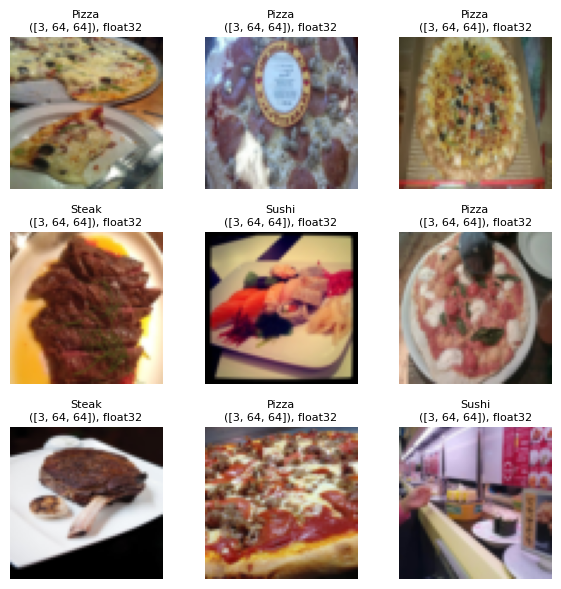

In [59]:
plt_random_sample_from_data(train_data, 3 ,3)

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=80480